In [13]:
%matplotlib inline
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import math

Loading training data.

In [14]:
IMAGE_SIZE = 20
train_data = io.loadmat('ex4data1.mat')
X = np.insert(train_data['X'], 0, 1, axis=1) # add bias column at the beginning of X
y = train_data['y']
y[y==10]=0 # convert matlab index to python index

Visual training data.

In [15]:
def display_data(data):
    m,n = data.shape
    row_width = int(np.sqrt(m))
    img_width = img_height = int(np.sqrt(n))
    img_show = np.empty((row_width*img_width, img_width*row_width))
    for i in range(row_width):
        for j in range(row_width):
            img_show[img_height*i:(img_height*i)+img_height, img_width*j:img_width*j + img_width] = \
            np.reshape(data[i*row_width + j, :], (img_height, img_width), order='F')
            
    plt.imshow(img_show)

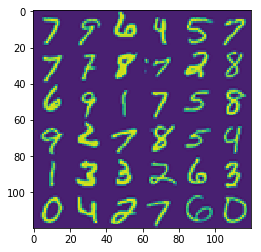

In [16]:
idx = np.random.randint(X.shape[0], size=36)
display_data(X[idx, 1:])

Implement sigmoid activation function.

In [63]:
def sigmoid(value):
    return 1 / (1 + math.e ** (-value))

Compute feedfoward prediction, our neural network have 3 layout: 1 input, 1 hidden and 1 output layout.
So we will have 2 weight matrix that need to update: W1 with size 25x401 mapping from input layout to hidden layout and W2 with size 10x26 mapping from hidden layout to output layout.

In [18]:
# define neural network architecture
INPUT_LAYER_SIZE = 400
HIDDEN_LAYER_SIZE = 25
OUTPUT_LAYER_SIZE = 10

In [178]:
def randomInitialize():
    """construct our Weights matrix"""
    epsilon = 0.001
    W1 = np.random.uniform(-epsilon, epsilon, (HIDDEN_LAYER_SIZE, INPUT_LAYER_SIZE+1))
    W2 = np.random.uniform(-epsilon, epsilon, (OUTPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE+1))

    return [W1, W2]

In [20]:
def feedforward(X, Ws):
    a = X
    for i, W in enumerate(Ws):
        z = np.dot(W, a.T)
        a = sigmoid(z)
        if(i != (len(Ws)) - 1) : # not output layer
            a = np.insert(a.T, 0, 1, axis=1)

    return a.T

Transform y from vector to big Y matrix contains only 0 and 1, where each row now is not a number but a vector.
If $x^{i}$ is correctsponding to the number 5  then $y^{i}$ would be a vector where $y_i$ = 1 and the rest is 0

In [21]:
Y = np.zeros((y.shape[0], OUTPUT_LAYER_SIZE))
for i in range(OUTPUT_LAYER_SIZE):
    Y[np.where(y==i)[0], i] = 1

Compute neural network cost function

In [22]:
def nnRegularization(Weights, num_examples,  _lambda):
    reg = 0
    for ws in Weights:
        reg += np.dot(ws[:, 1:].ravel().T, ws[:, 1:].ravel())
    
    return (_lambda / (2*num_examples)) * reg

In [23]:
def nnCostFunction(Weights, X, Y, _lambda=0):
    m,_ = X.shape
    NUM_LABELS = Y.shape[1]
    h_x = feedforward(X, Weights)
    Cost = 0
    for i in range(NUM_LABELS): # Sum cost of each node in output layer
        Cost += -np.dot(Y[:,[i]].T, np.log(h_x[:,[i]])) - np.dot((1-Y[:,[i]]).T, np.log(1 - h_x[:,[i]]) )
    Cost /= m
    reg = nnRegularization(Weights, m, _lambda)
    
    return Cost + reg

Compute derivative of sigmoid activation function

In [25]:
def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

Compute partial derivative of all the Weights in out neural network model using back propagation algorithm

In [210]:
def backPropagation(Weights, X, Y, alpha=1, _lambda=0):
    """
    Return a list with same size with Weights,
    Each element is the partial derivative term of Neural network cost function with respect to the each weights.
    """
    
    m,n = X.shape
    a1 = X
    z2 = np.dot(Weights[0], a1.T)
    a2 = sigmoid(z2.T)
    a2 = np.insert(a2, 0, 1, axis=1)
    z3 = np.dot(Weights[1], a2.T)
    h = sigmoid(z3.T)
    
    delta3 = h - Y
    delta2 = np.dot(delta3, Weights[1][:,1:]) * sigmoidGradient(z2.T)
    
    W2_grad = np.dot(delta3.T, a2) * (alpha/m)
    W1_grad = np.dot(delta2.T, X)  * (alpha/m)
    
    W1_grad[:,1:] += W1_grad[:,1:] * (_lambda / m)
    W2_grad[:,1:] += W2_grad[:,1:] * (_lambda / m)
#     print(W2_grad)
    return [W1_grad, W2_grad]


Start training our neural network using mini batch gradient descent

In [211]:
def trainNN(Weights, X, Y, alpha=1, _lambda=0, batch_size=5000, stochastic_loop=1):
    m,n = X.shape
    
    for loop in range(stochastic_loop):
        for i in range(0, m, batch_size):
            W_grad = backPropagation(Weights, X[i:i+batch_size], Y[i:i+batch_size], alpha, _lambda)
            Weights[0] -= W_grad[0]
            Weights[1] -= W_grad[1]
           
        print('Iteration %d - Cost : %s' %  ( loop, str(nnCostFunction(Weights, X, Y, _lambda))), end='\r')
    return Weights

In [212]:
Weights = randomInitialize()

In [ ]:
Weights = trainNN(Weights, X, Y, alpha=2, _lambda=1, batch_size=512, stochastic_loop=100)

Compute accuracy of our model on data set

In [192]:
def predict(Weights, X):
    hx = feedforward(X, Weights)
    m,_ = X.shape
    predict = np.argmax(hx, axis=1).reshape((m, 1))
    
    return predict

In [205]:
def score(Weights, X, y):
    m,_ = X.shape
    return sum(predict(Weights, X)==y) / m

In [215]:
score(Weights, X, y)

array([ 0.9496])